In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)


In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('Confusin Matrix')
  print(confusion)
  print('Accuracy : {0:.4f}, Precision : {1:.4f}, Recall : {2:.4f}, F1-Score : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 보팅

* 두 개 이상의 다른 유형의 모델을 결합하여 예측하는 방식
* 보통은 소프트보팅 방식을 사용한다 

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# 로지스틱 모델과 KNN모델 생성
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)
# 위 두 모델을 결합하여 보팅 모델 생성
vo_clf = VotingClassifier(estimators=[('LR',lr_clf), ('KNN',knn_clf)], voting='soft')
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# 보팅모델의 스코어 파악
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting accuracy : {0:.4f}'.format(accuracy_score(y_test, pred)))
print('Voting F1-score : {0:.4f}'.format(f1_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

classifier = [lr_clf, knn_clf]

# 비교를 위해 각 모델 별 스코어 출력 
for classifier in classifier :
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} accurcy : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))
  print('{0} F1-score : {1:.4f}'.format(class_name, f1_score(y_test, pred)))
  print(confusion_matrix(y_test, pred))

Voting accuracy : 0.9474
Voting F1-score : 0.9620
[[32  5]
 [ 1 76]]
LogisticRegression accurcy : 0.9386
LogisticRegression F1-score : 0.9554
[[32  5]
 [ 2 75]]
KNeighborsClassifier accurcy : 0.9386
KNeighborsClassifier F1-score : 0.9542
[[34  3]
 [ 4 73]]


## 랜덤포레스트(중요)
* 배깅방식(같은 종류의 여러 모델을 학습 후 보팅으로 최종결정하는 알고리즘)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print('랜덤포레스트 디폴트 파라미터 정확도 : {0:.4f}'.format(accuracy_score(y_test,pred)))
print('랜덤포레스트 디폴트 파라미터 F1-score : {0:.4f}'.format(f1_score(y_test,pred)))

params = {
    'n_estimators':[100], # 결정트리의 개수
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}
# n_jobs = -1 은 동시에 여러코어를 사용하여 학습시간을 단축시키려고 사용
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

랜덤포레스트 디폴트 파라미터 정확도 : 0.9561
랜덤포레스트 디폴트 파라미터 F1-score : 0.9677
최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9451


In [ ]:
# 분류에 사용하는 트리의 개수를 300개로 늘려서 확인 -> 예측 정확도가 오히려 떨어짐 -> 많다고 좋은게 아니다!!!

rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('랜덤포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test,pred)))
print('랜덤포레스트 F1-score : {0:.4f}'.format(f1_score(y_test,pred)))

랜덤포레스트 정확도 : 0.9386
랜덤포레스트 F1-score : 0.9542


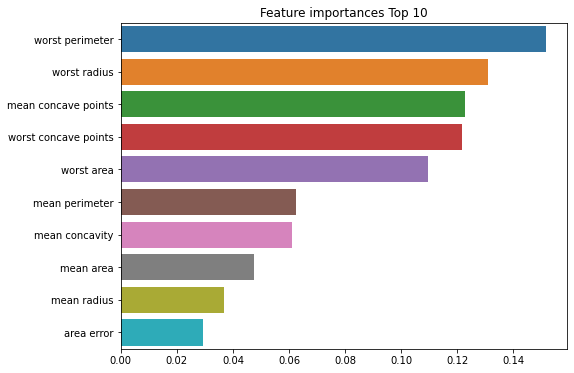

In [ ]:
# 피처중요도 시각화

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances_values = pd.Series(ftr_importances_values, index=cancer.feature_names)
ftr_top10 = ftr_importances_values.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 10')
sns.barplot(x=ftr_top10, y= ftr_top10.index)
plt.show()

## GBM(Gradient Boosting Machine)
* weak learner를 순차적으로 학습시키며 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해가며 학습하는 방식


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

print('GBM Accuracy : {0:.4f}'.format(accuracy_score(y_test, gb_pred)))

# GBM모델의 수행시간을 체크하기 위해서
print("GBM time : {0:.1f}sec".format(time.time()-start_time))

GBM Accuracy : 0.9561
GBM time : 0.4sec


In [ ]:
# 일반적으로 n_estimators 가 커지면 성능이 좋아지지만 수행시간이 증가한다. 디폴트는 100
# 일반적으로 learning_rate가 작으면 성능이 좋아지지만 수행시간이 증가한다. 디폴트는 0.1, 0~1값을 갖는다.
# 두 변수는 상호 보완적으로 사용해야함

params={
    'n_estimators':[100,200],
    'learning_rate':[0.05, 0.1]
}
# verbose=1 은 전체 과정 한번만 보여주는것, 1보다 크면 각각의 트리에따른 결과물을 출력한다. 디폴트는 0(출력 안함)
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.7s finished


최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 100}
최고 예측 정확도 : 0.9385


In [ ]:
# 선택된 최적의 파라미터를 사용해 예측, 이 경우에는 선택된 파라미터가 기본값과 같으므로 정확도도 같음.
gb_pred=grid_cv.best_estimator_.predict(X_test)
print('GBM Accuracy : {0:.4f}'.format(accuracy_score(y_test, gb_pred)))

GBM Accuracy : 0.9386


## XGBoost
**장점 : 뛰어난 예측성능, 과적합규제, 나무 가지치기, 자체 내장 교차검증, 견손값 자체처리**

---


- XGB모델은 파라미터를 fit에다가 적용시킨다. 
- early_stopping_rounds=100 은 평가 지표가 어느 지점에서 100번째까지 향상되지 않는다면 조기 종료하겠다는 옵션, 너무 급격하게 줄이면 성능향상의 여지가 있는데 조기종료되어 모델의 성능이 저하될 수 있으므로 적절한 수를 선택해야한다.
- eval_metric='logloss' 는 평가지표로 logloss를 사용하겠다는 옵션
- eval_set=[(X_test, y_test)]는 평가를 할 데이터셋을 명시, 이 데이터는 충분히 크지 않아 테스트 셋으로 사용하였지만 이는 과적합의 원인이 될 수 있으므로 모델 테스트 시에는 아예 알려지지 않은 데이터 셋을 사용하는게 바람직 하다.
- verbose는 각 과정을 보여주느냐 마느냐를 명시, 디폴트값은 0으로 각 과정을 보여주지 않는것으로 되어있다.
- (중요) 목적에 맞게 objective(회귀,이진분류, 다중분류 등)와 그에 맞는 평가지표(eval_metric)를 설정해 주어야 한다

In [ ]:
from xgboost import XGBClassifier
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

xgb_clf = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_clf.fit(X_train, y_train)
pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred = pred, pred_proba=pred_proba)

Confusin Matrix
[[35  2]
 [ 1 76]]
Accuracy : 0.9737, Precision : 0.9744, Recall : 0.9870, F1-Score : 0.9806, AUC : 0.9951


In [ ]:
xgb_clf = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

# XGB모델은 파라미터를 fit에다가 적용시킨다. 
# early_stopping_rounds=100 은 평가 지표가 어느 지점에서 100번째까지 향상되지 않는다면 조기 종료하겠다는 옵션, 너무 급격하게 줄이면 성능향상의 여지가 있는데 조기종료되어 모델의 성능이 저하될 수 있으므로 적절한 수를 선택해야한다.
# eval_metric='logloss' 는 평가지표로 logloss를 사용하겠다는 옵션
# eval_set=[(X_test, y_test)]는 평가를 할 데이터셋을 명시, 이 데이터는 충분히 크지 않아 테스트 셋으로 사용하였지만 이는 과적합의 원인이 될 수 있으므로 모델 테스트 시에는 아예 알려지지 않은 데이터 셋을 사용하는게 바람직 하다.
# verbose는 각 과정을 보여주느냐 마느냐를 명시, 디폴트값은 0으로 각 과정을 보여주지 않는것으로 되어있다.
# (중요) 목적에 맞게 objective(회귀,이진분류, 다중분류 등)와 그에 맞는 평가지표(eval_metric)를 설정해 주어야 한다
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, objective = 'binary:logistic', eval_metric='logloss', eval_set=[(X_test, y_test)], verbose=0)
pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred = pred, pred_proba=pred_proba)

Confusin Matrix
[[34  3]
 [ 1 76]]
Accuracy : 0.9649, Precision : 0.9620, Recall : 0.9870, F1-Score : 0.9744, AUC : 0.9954


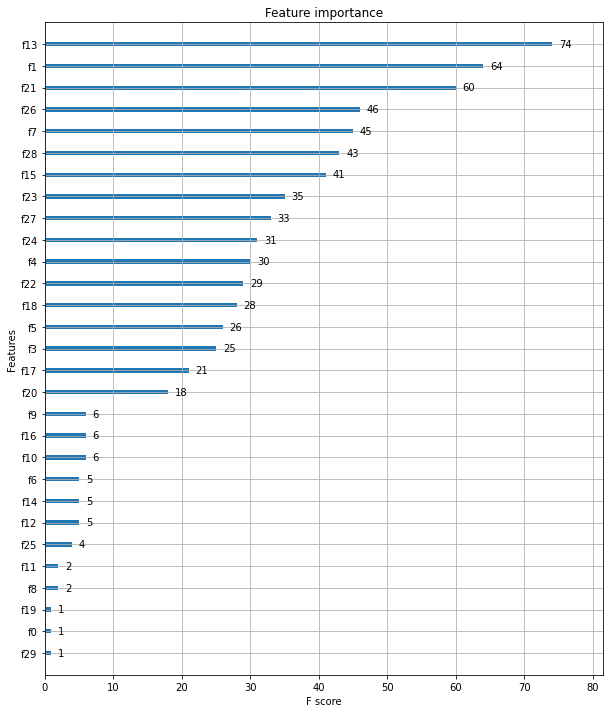

In [ ]:
# xgboost 안의 plot_importance를 활용해서 변수의 중요도를 시각화 할 수 있다. 
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_clf, ax=ax)

# numpy로 데이터 학습을 시켰기 떄문에 변수명이 f0,f1...로 변환되어 나타난다. 뒤에 숫자는 변수의 순서

## LightGBM

* 다른 부스팅 방식과는 다르게 리프중심트리분할을 사용한다.
* 카테고리형 피처의 자동변환과 최적 분할(원-핫인코딩 사용하지 않아도 최적으로 변환하고 이에 따른 노드 분할 수행)
* 일반적 부스팅계열 튜닝 : n_estimator, learning_rate
* num_leaves의 개수를 중심으로 min_child_samples, max_depth를 함께 조정하며 모델의 복잡도를 줄인다

In [ ]:
from lightgbm import LGBMClassifier

cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
target_df = pd.Series(cancer.target)
X_train, X_test, y_train, y_test = train_test_split(data_df, target_df, test_size=0.2, random_state=156)

lgb_clf = LGBMClassifier(n_estimators=400, learning_rate=0.1)
lgb_clf.fit(X_train, y_train, early_stopping_rounds=100, objective = 'binary:logistic', eval_metric='logloss', eval_set=[(X_test, y_test)], verbose=0)

pred = lgb_clf.predict(X_test)
pred_proba = lgb_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

Confusin Matrix
[[33  4]
 [ 2 75]]
Accuracy : 0.9474, Precision : 0.9494, Recall : 0.9740, F1-Score : 0.9615, AUC : 0.9926


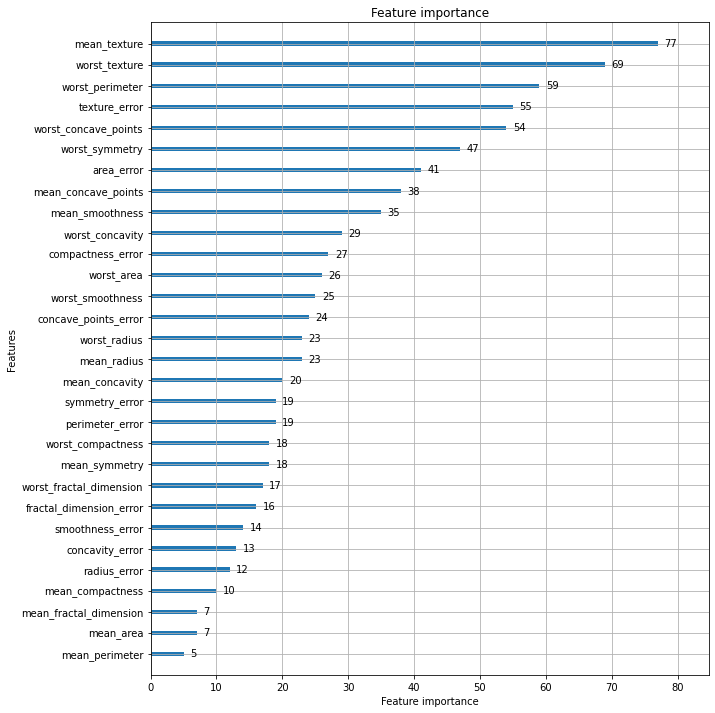

In [ ]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgb_clf, ax=ax)
# 데이터프레임으로 시각화 하면 변수명 정상적으로 출력